# Laboratorium 3

### Konfiguracja

In [1]:
!python -m pip install sortedcontainers
import numpy as np
import heapq 
import functools
import math
import random
from sortedcontainers import SortedSet
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection([]))

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


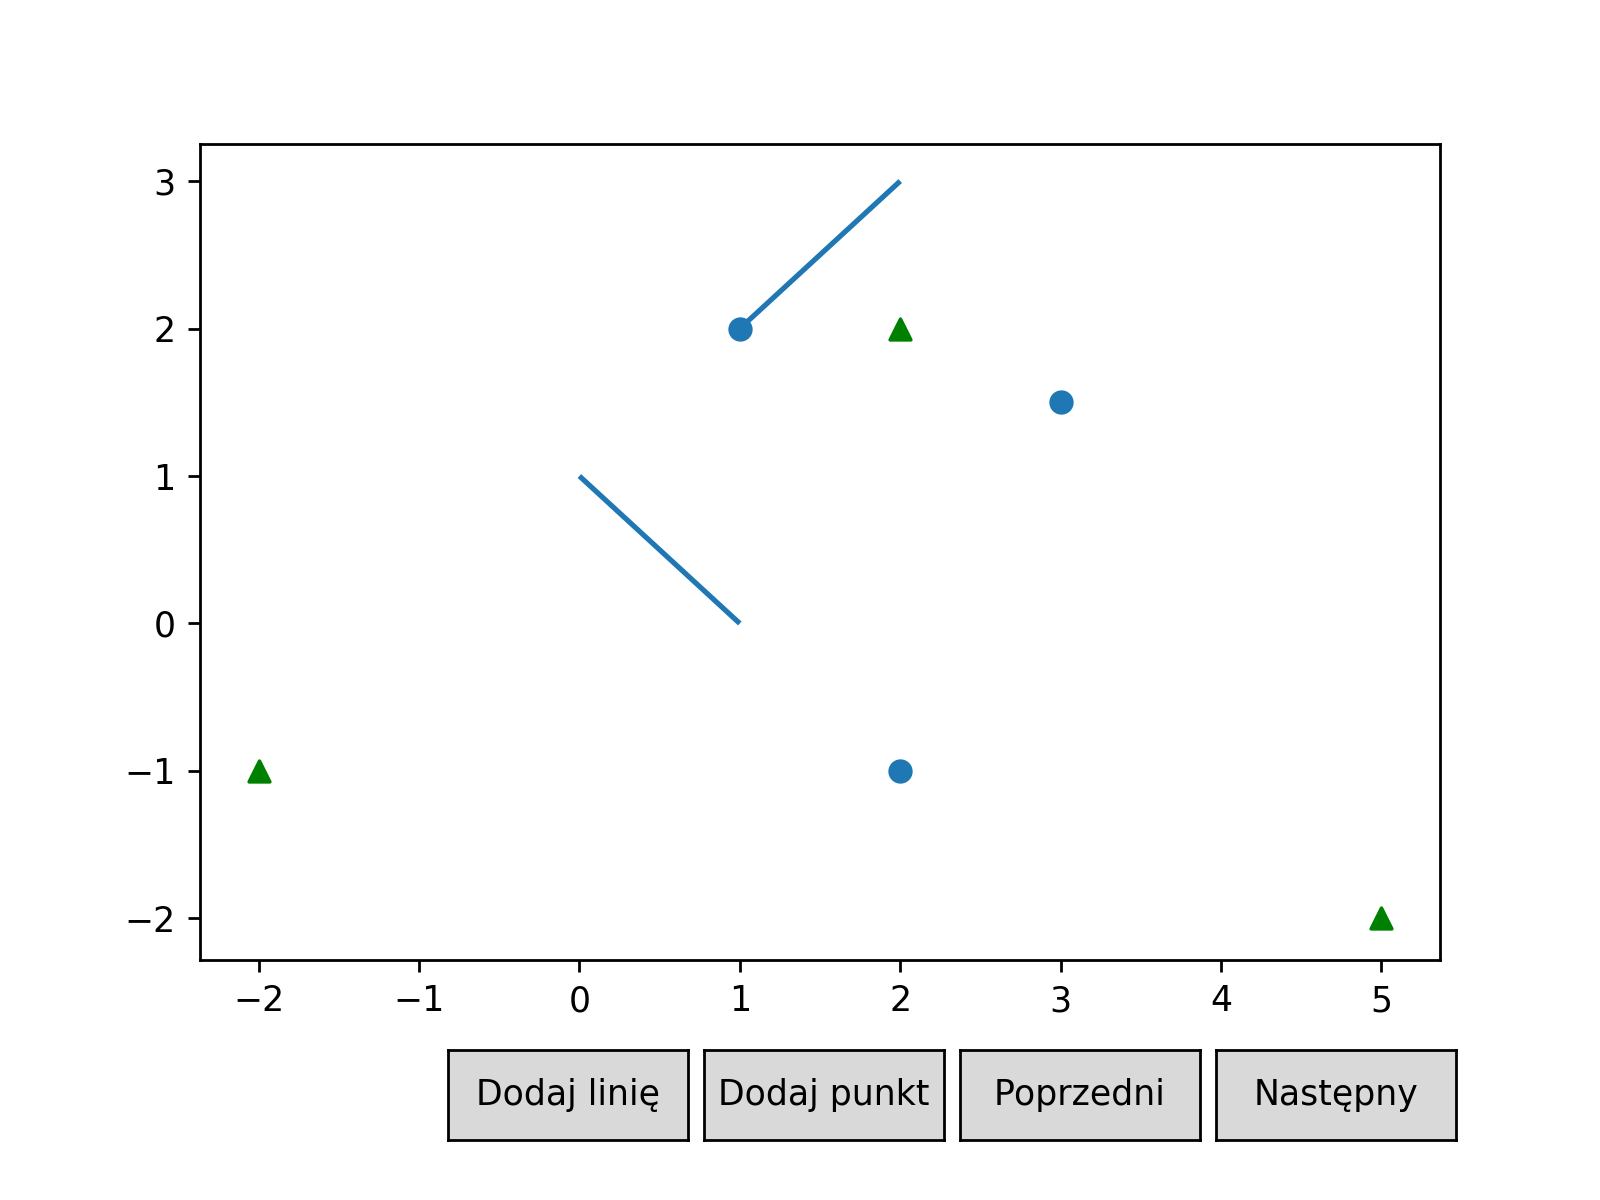

In [3]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red', s=1), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.add_scene(Scene([PointsCollection([(2, 1)])], [LinesCollection([[(1,2),(2,3)]])]))

plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


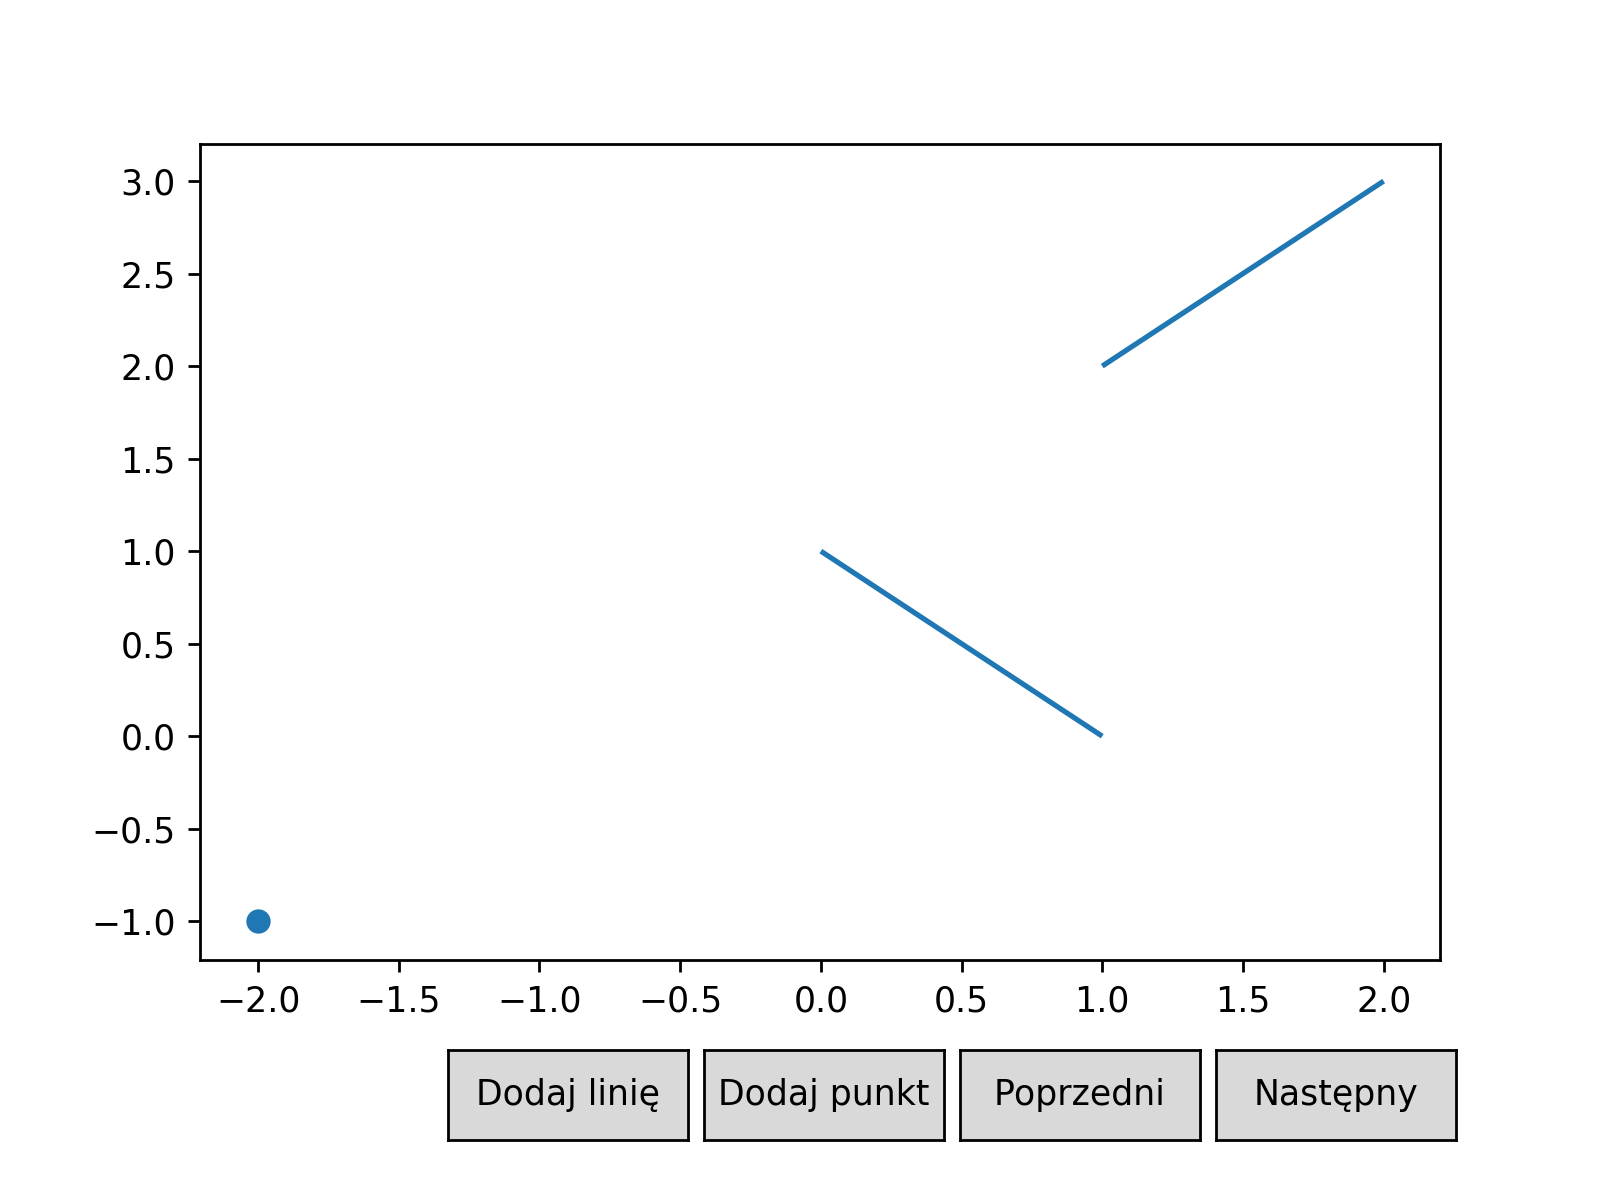

In [4]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


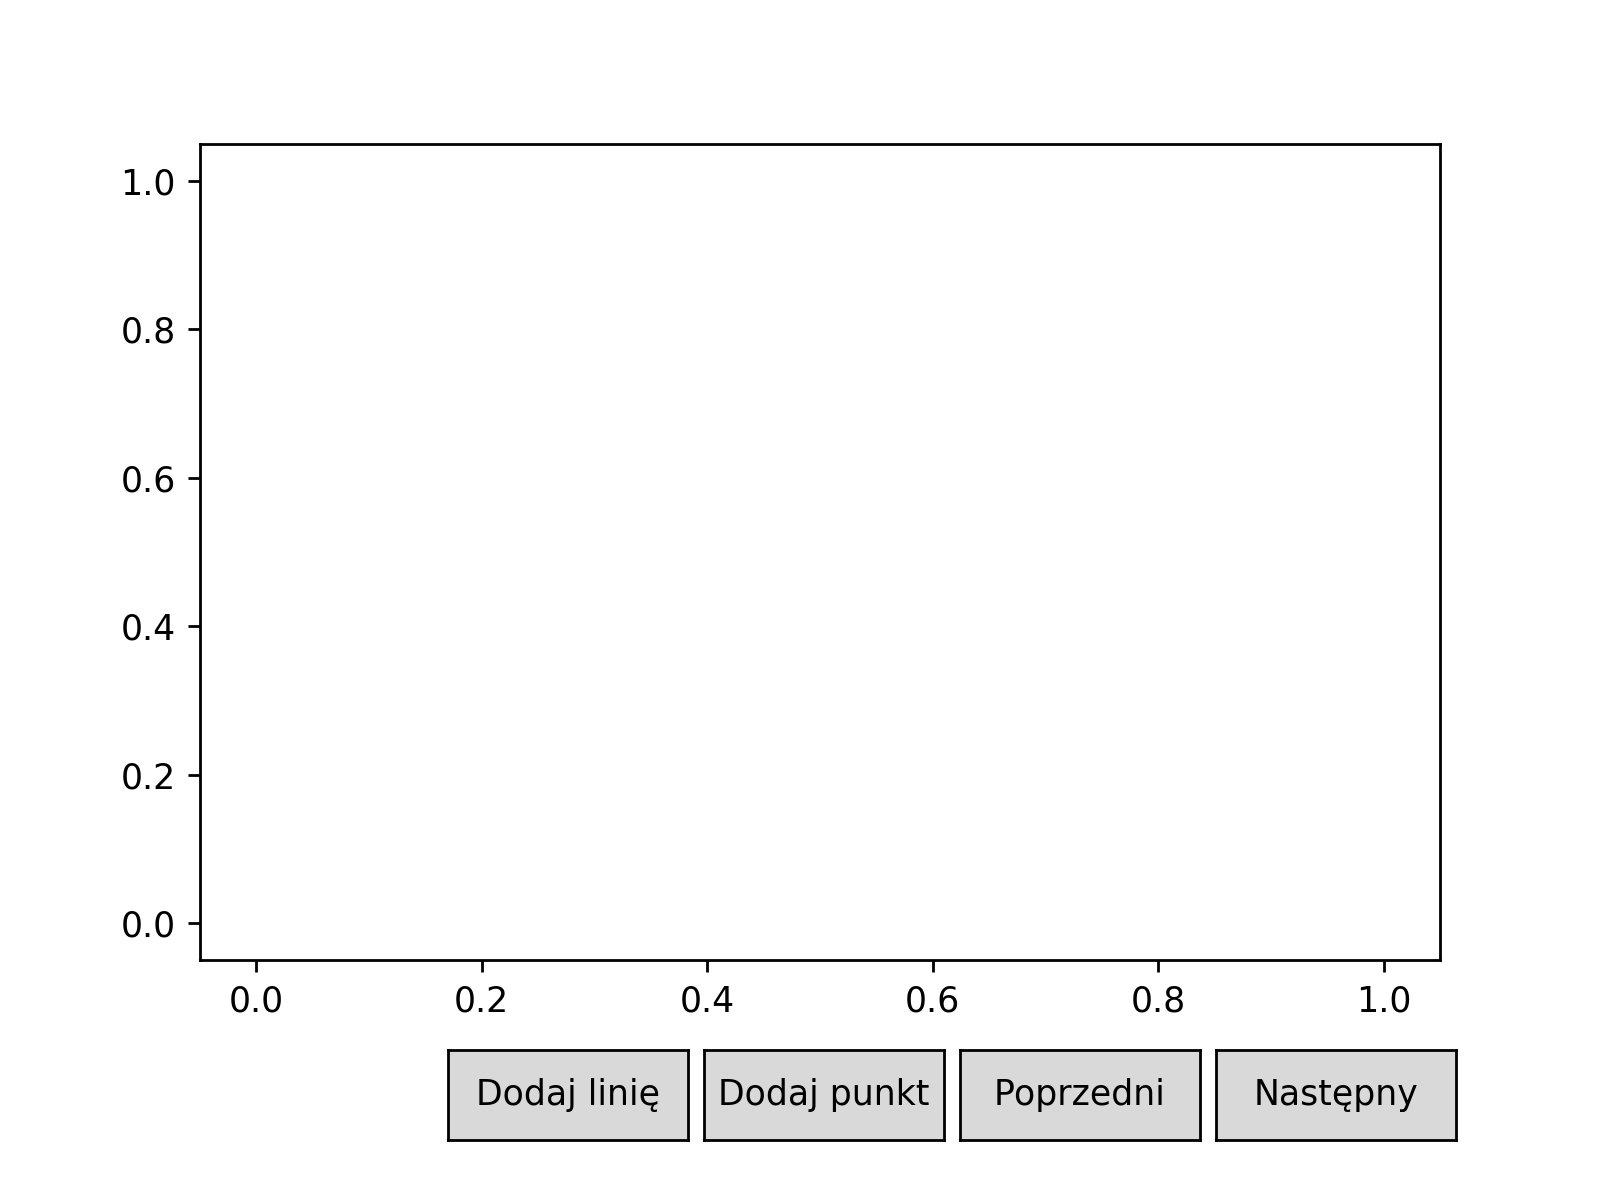

In [5]:
#Dodaj tu punkty i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


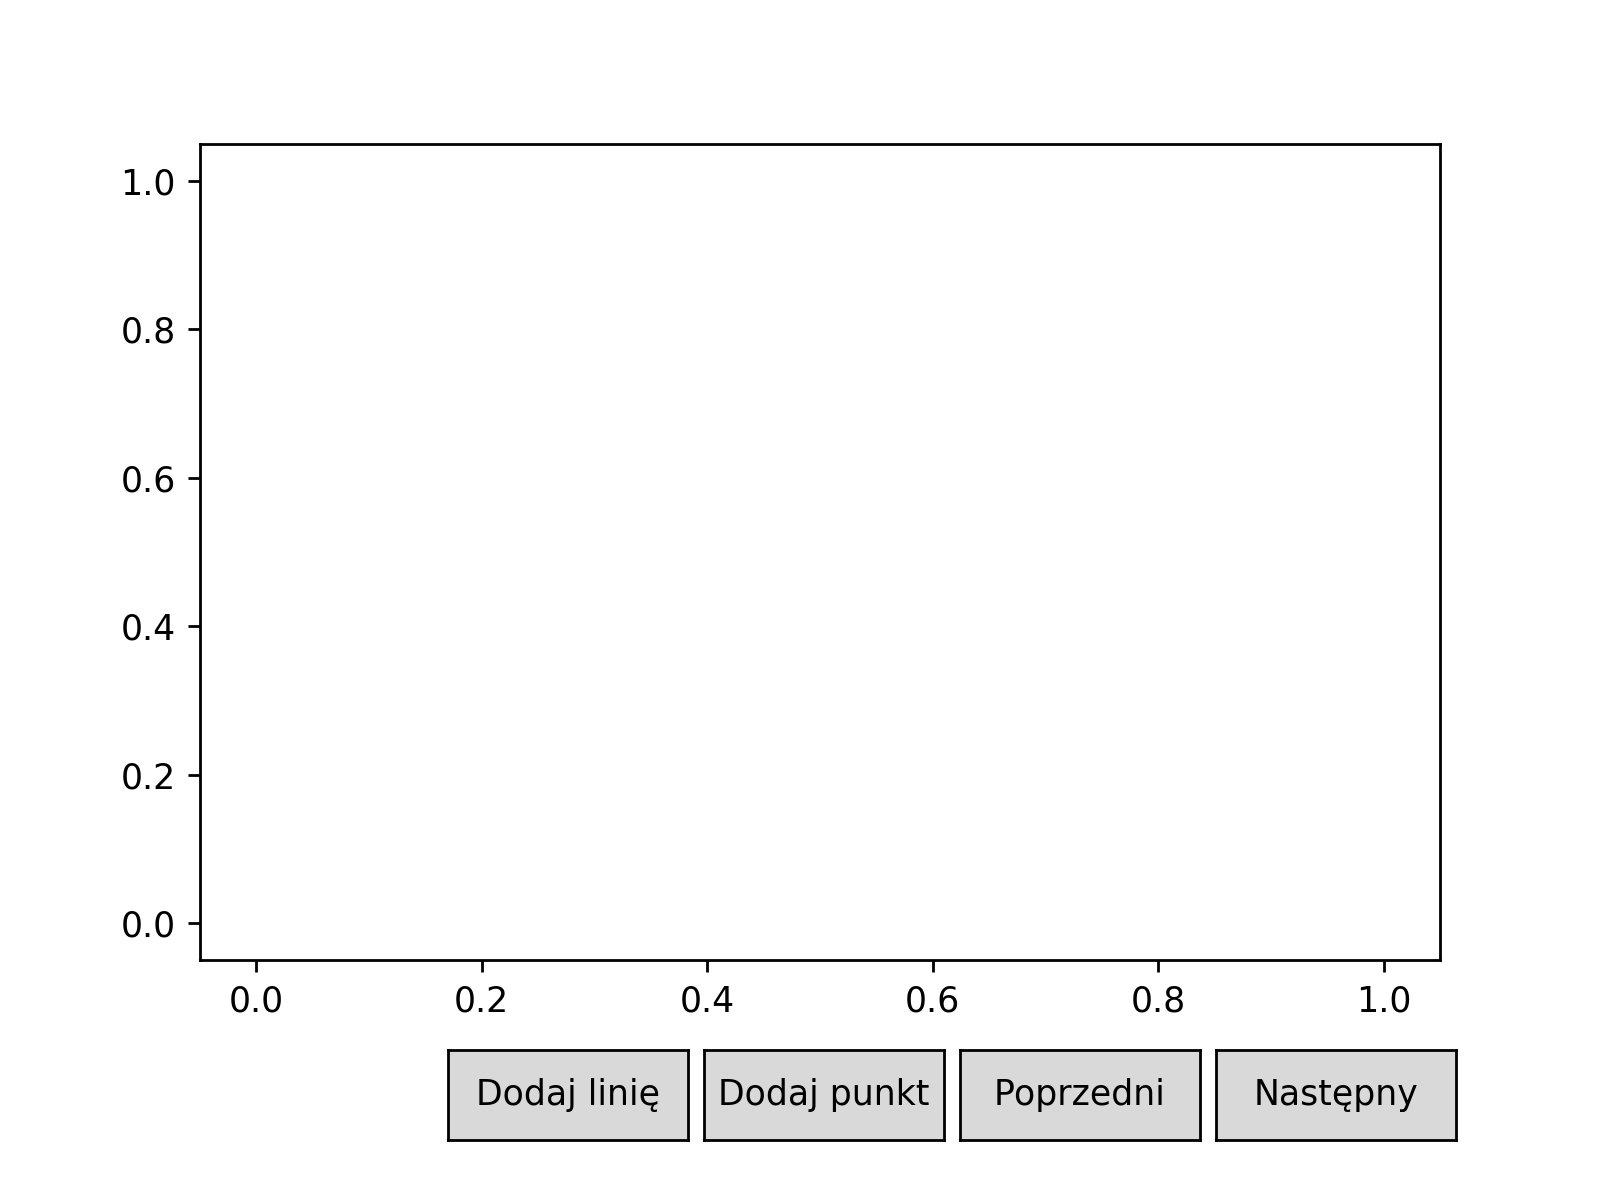

In [6]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie
#### Generowanie i filtrowanie
Pniżej znajduje się kod pozwalający na generowanie zbioru losowych lini na danym obszarze, oraz algorytm filtrujący zadany zbiór z lini pionowych oraz współdzielących początek/koniec.

In [7]:
def filter_lines(epsilon, lines):

    lines = [sorted(line) for line in lines]
    
    for m in lines:
        for n in lines:
            if m != n:
                if distance(m[0],n[0]) < epsilon or distance(m[1],n[1]) < epsilon or distance(m[1],n[0]) < epsilon or distance(m[0],n[1]) < epsilon:
                    lines.remove(n)

    return list(filter(lambda line: abs(line[0][0] - line[1][0]) > epsilon, lines))

def generate_random_point(range_a, range_b):
    return random.uniform(range_a[0], range_a[1]),random.uniform(range_b[0], range_b[1])
    
    
def generate_random_line(range_a, range_b):
    return [generate_random_point(range_a, range_b),generate_random_point(range_a, range_b)]


def generate_unique_random_lines(n, range_a, range_b, epsilon = 0.1):
    lines = []   
    while len(lines) < n:
        lines.append(generate_random_line(range_a, range_b))
        lines = filter_lines(epsilon, lines)
    return lines

def distance(point_a, point_b):
    return math.sqrt(math.pow(point_a[0]-point_b[0],2)+math.pow(point_a[1]-point_b[1],2))
    
    
    
def filter_plot(epsilon, scene):
    if(len(scene.lines) == 0): 
        return scene
    
    return Scene(scene.points, lines=[LinesCollection(filter_lines(epsilon, scene.lines[0].lines))])

#### Filtrowanie

<IPython.core.display.Javascript object>


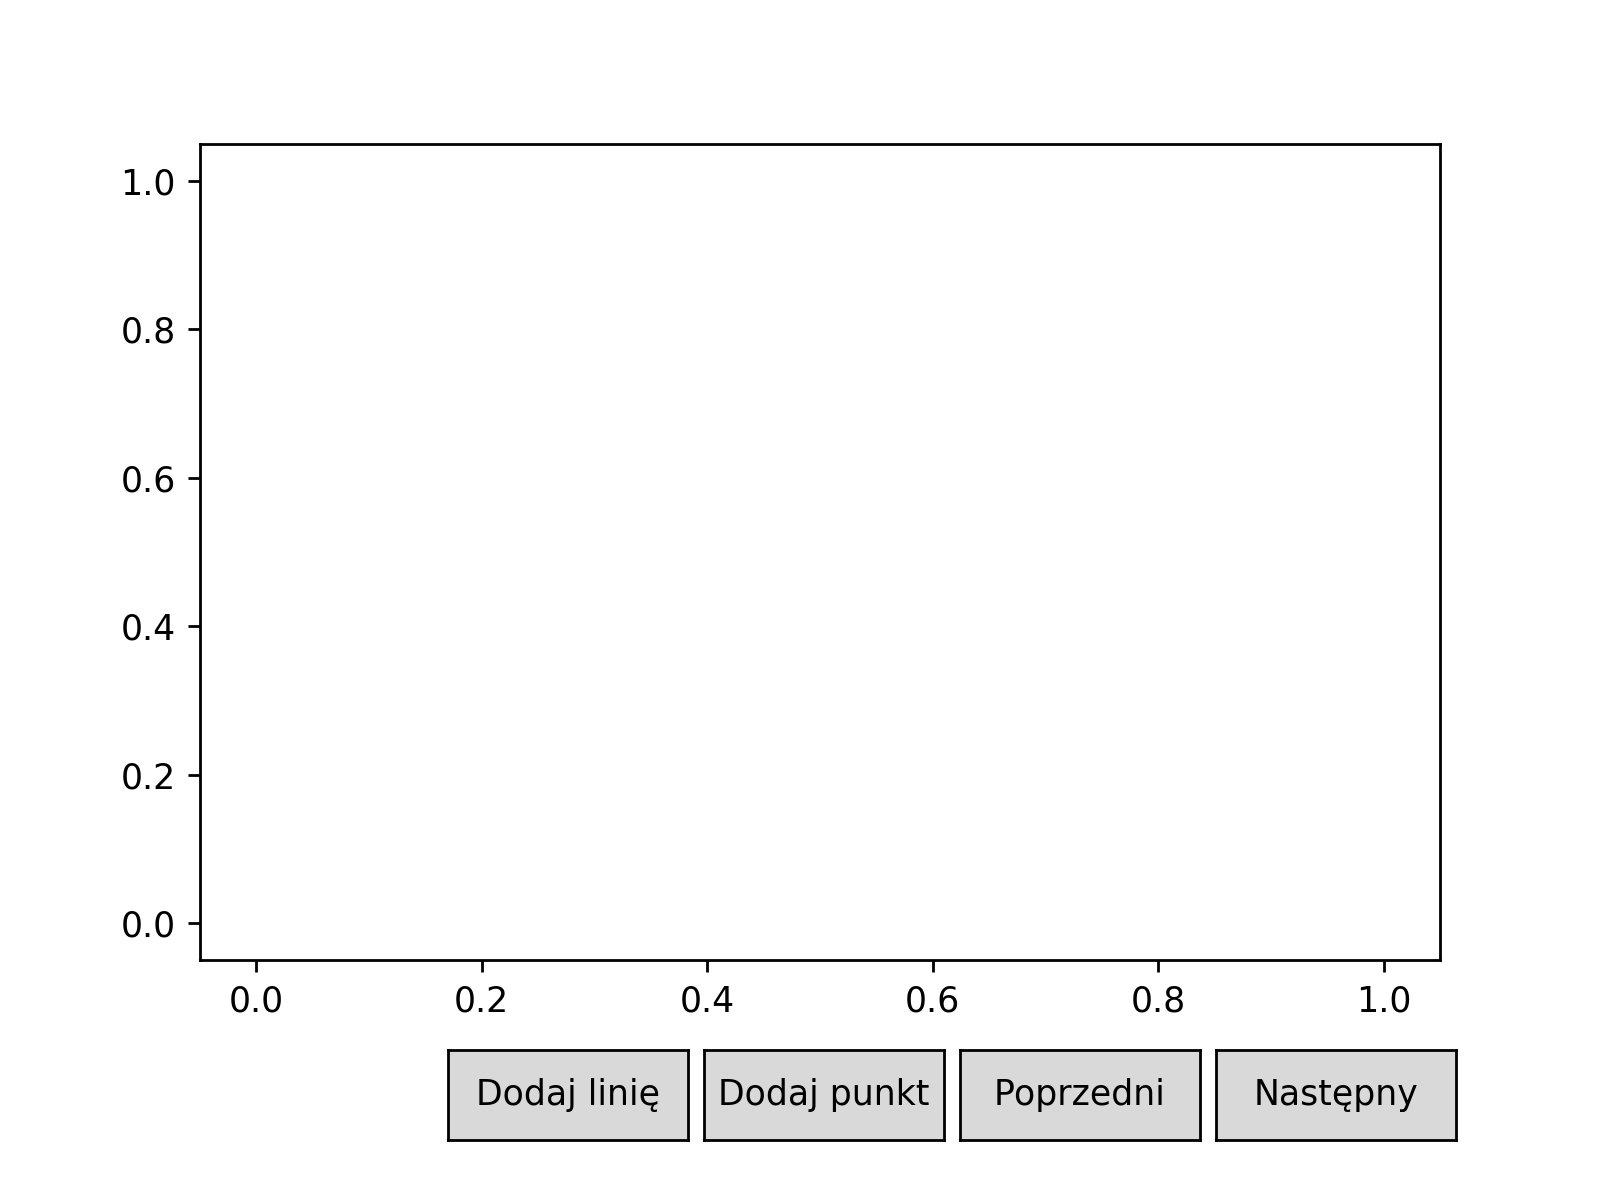

In [8]:
#Dodaj tu punkty i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


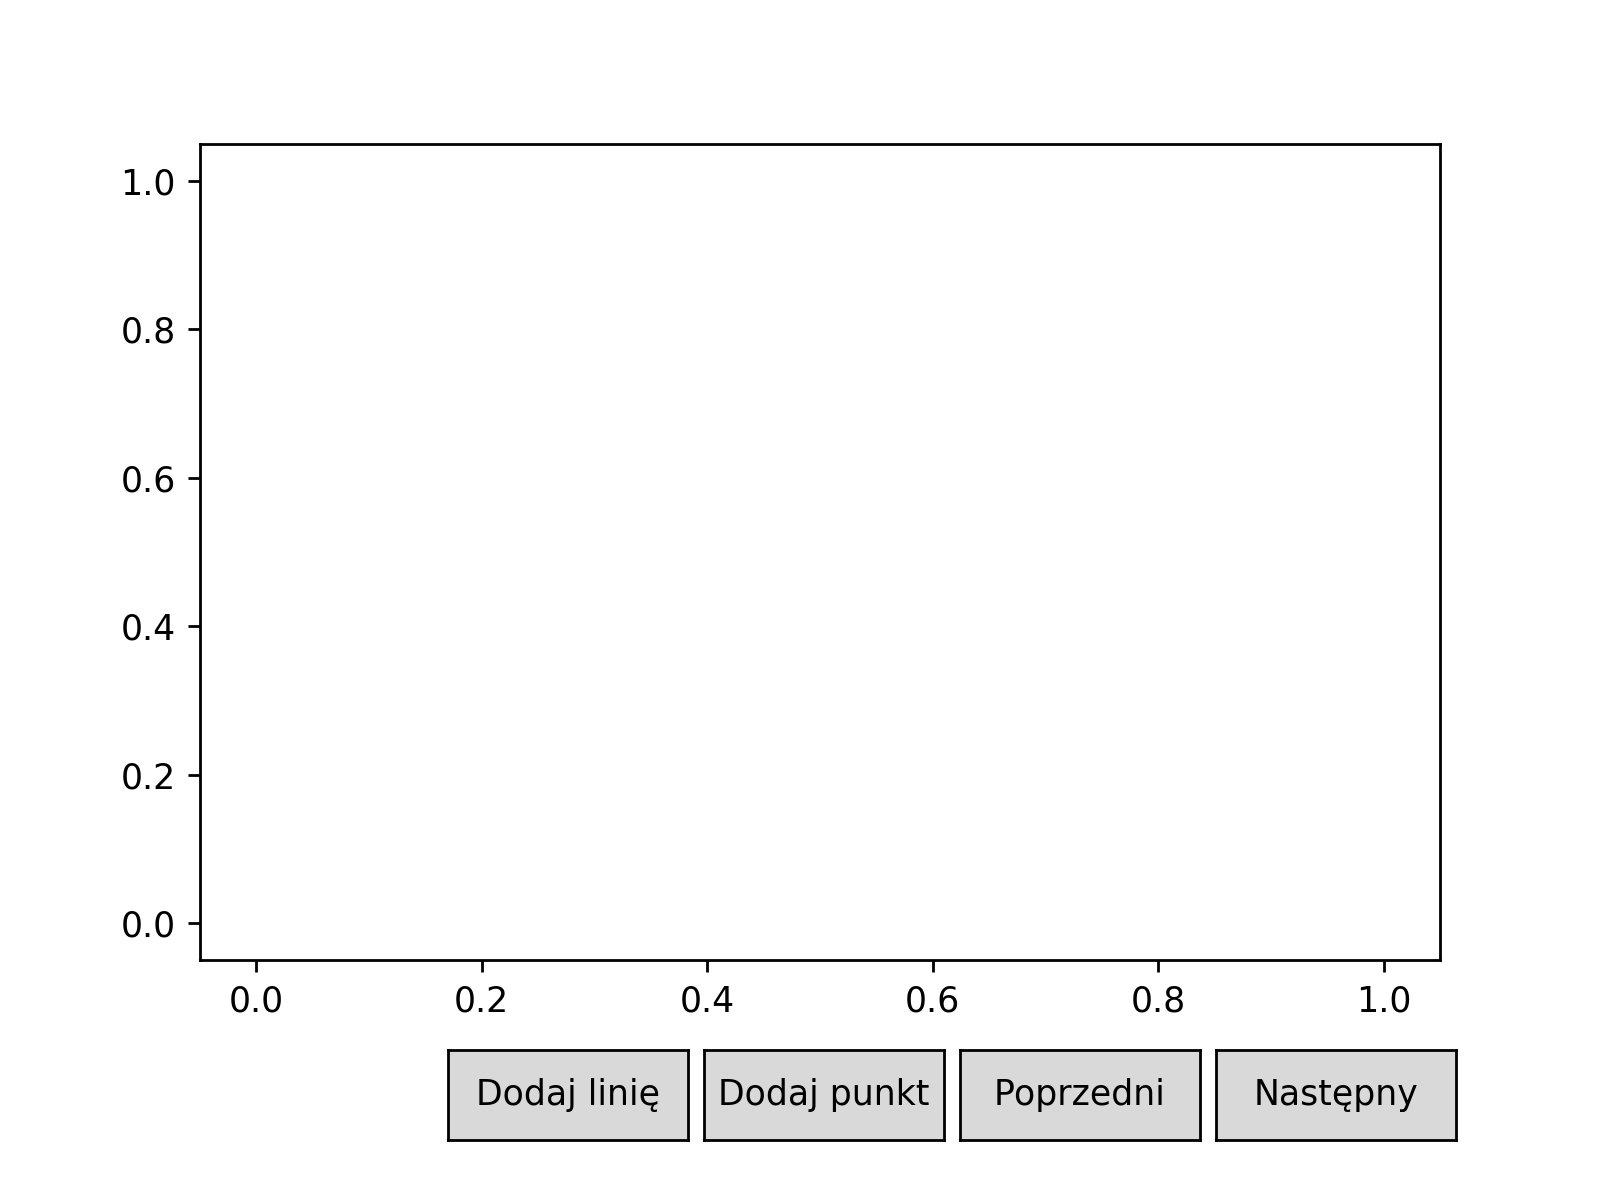

In [9]:
plot2 = Plot([filter_plot(0.01,plot1.get_added_elements())])
plot2.draw()

#### Generowanie losowych linii

<IPython.core.display.Javascript object>


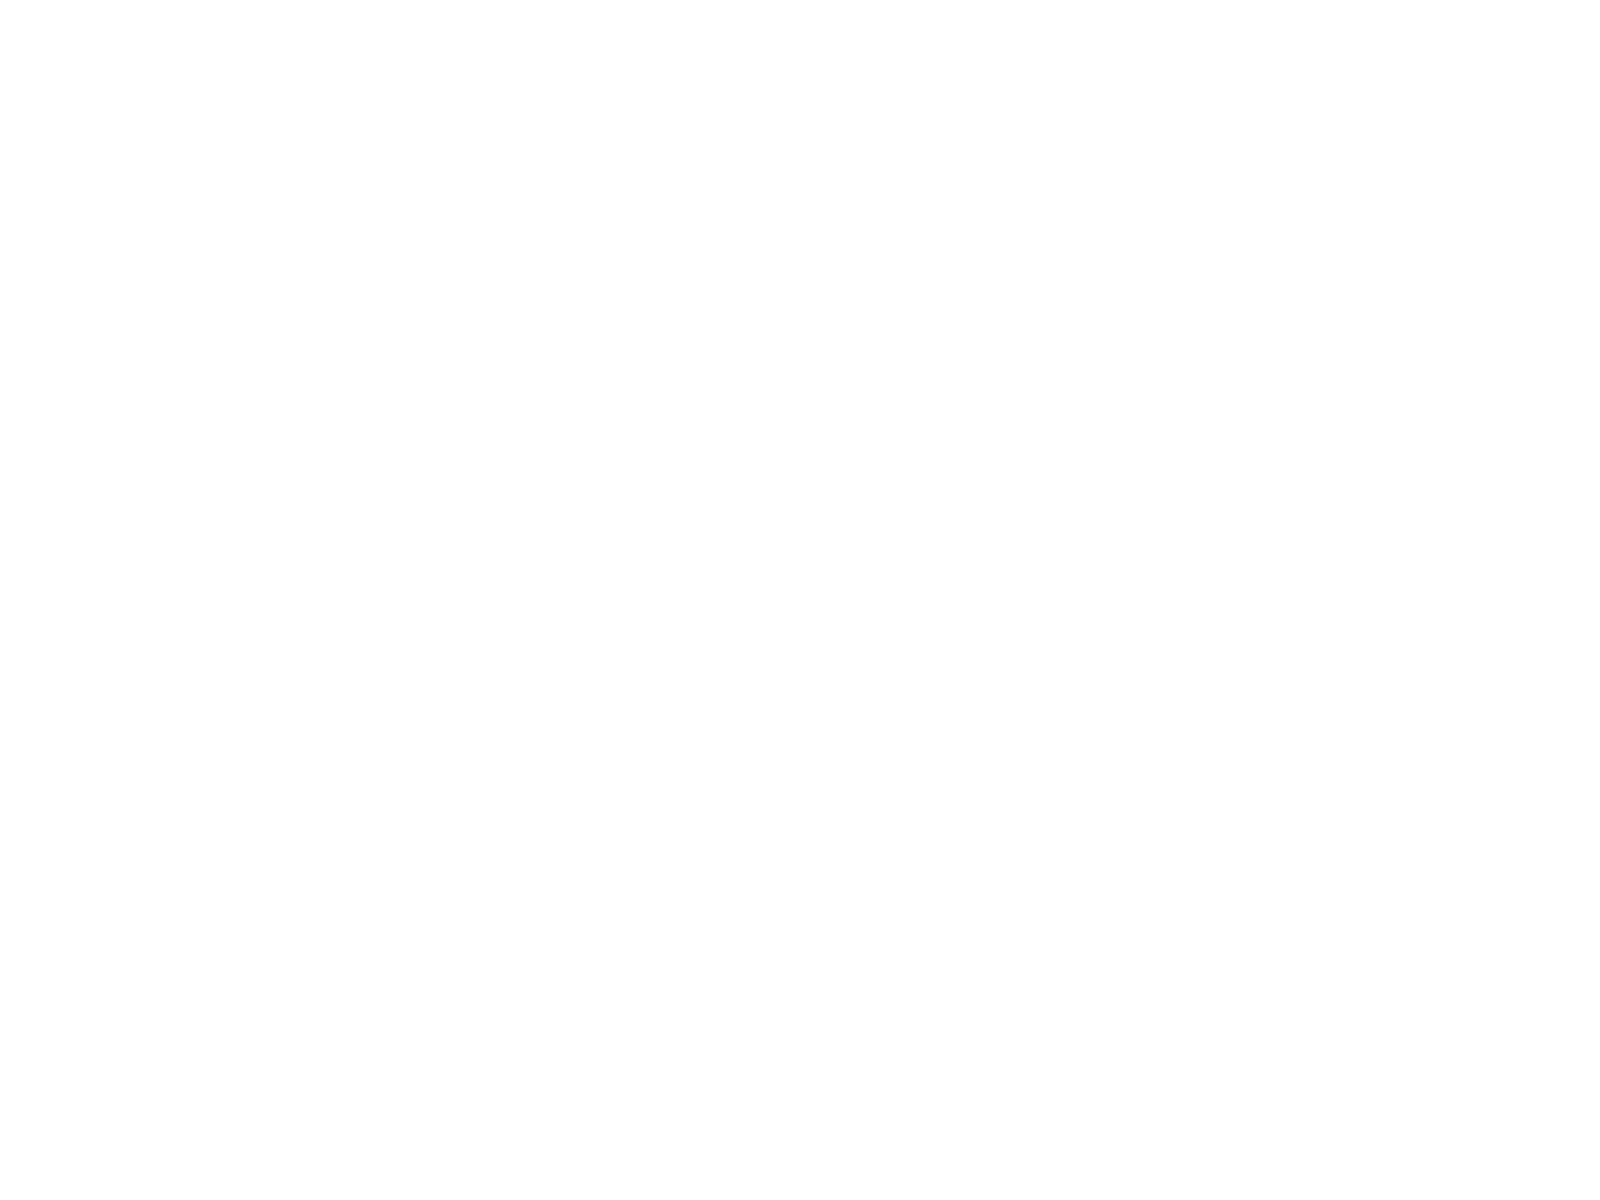

In [10]:
plot3 = Plot([Scene(lines=[LinesCollection(generate_unique_random_lines(30, (0,1), (0,1)))])])
plot3.draw()

#### Funkcje pomocnicze do znajdowania przecięć

In [11]:
def numpy_det(array):
    return np.linalg.det(np.array(array))

def intersect(line_1, line_2, epsilon=0.001):
    line_1 = sorted(line_1)
    line_2 = sorted(line_2)
    slope_1, intercept_1, r_value, p_value, std_err = linregress([line_1[0][0],line_1[1][0]],[line_1[0][1],line_1[1][1]])
    slope_2, intercept_2, r_value, p_value, std_err = linregress([line_2[0][0],line_2[1][0]],[line_2[0][1],line_2[1][1]])
    W = numpy_det([[slope_1, -1],[slope_2, -1]])
    Wx = numpy_det([[-1*intercept_1,-1],[-1*intercept_2,-1]])
    Wy = numpy_det([[slope_1, -1*intercept_1],[slope_2, -1*intercept_2]])
    x = 0
    y = 0
    if(W != 0):
        x = Wx/W
        y = Wy/W
    
    if x < line_1[1][0]+epsilon and x > line_1[0][0]-epsilon and x < line_2[1][0]+epsilon and x > line_2[0][0]-epsilon:
            return (True,(x,y))
    else:
        return (False,(x,y))
    
def round_point(p, r=2):
    return (round(p[0],r),round(p[1],r))

def round_line(l, r=2):
    return [round_point(l[0],r), round_point(l[1],r)]

#### Algorytm zamiatania

In [12]:
class Event:
    def __init__(self, x):
        self.x = x
    def __lt__(self, other):
        return isinstance(other, Event) and self.x < other.x

    
class StartOfLine(Event):
    def __init__(self, x, line):
        super().__init__(x)
        self.line = line

class EndOfLine(Event):
    def __init__(self, x, line):
        super().__init__(x)
        self.line = line
        
class LinesIntersection(Event):
    def __init__(self, x, lines):
        super().__init__(x)
        self.lines = lines
        
class Line:
    def __init__(self, line, id):
        self.line = line
        slope, intercept, r_value, p_value, std_err = linregress([line[0][0],line[1][0]],[line[0][1],line[1][1]])
        self.slope = slope
        self.intercept = intercept
        self.id = id
    def get_y(self, x):
        return self.slope*x+self.intercept

class SwipeState:
    def __init__(self, x):
        self.x = x
    
    def get_x(self):
        return self.x

    def get_previous(self):
        return self.previous

    def set_x(self, x):
        if(abs(x-self.x) > 0.001):
            self.previous = self.x
        self.x = x
        
def swipe(lines, scenes = []):
    result = set([])
    intersections = []
    min_y = 0
    max_y = 0
    
    for line in lines:
        min_line = min(line, key=lambda point: point[1])[1]
        max_line = max(line, key=lambda point: point[1])[1]
        min_y = min(min_y, min_line)
        max_y = max(max_y, max_line)
        
#     min_y = min(lines, key= lambda line: min(line, key=lambda point: point[1]))
#     max_y = max(lines, key= lambda line: max(line, key=lambda point: point[1]))
    lines = [Line(line, i) for i, line in enumerate(lines)]
    start_of_lines = list(map(lambda line: StartOfLine(line.line[0][0], line), lines))
    end_of_lines = list(map(lambda line: EndOfLine(line.line[1][0], line), lines))
    
    event_heap = []
    intersection_heap = []
    heapq.heapify(event_heap)
    heapq.heapify(intersection_heap)

    for start in start_of_lines:
        heapq.heappush(event_heap, (start.x, start))
    
    for end in end_of_lines:
        heapq.heappush(event_heap, (end.x, end))
    
    state = SwipeState(0)

    def comarator(line_a, line_b):
        result = line_a.get_y(state.get_x())-line_b.get_y(state.get_x())
        if(abs(result)< 0.001):
            result = line_a.slope - line_b.slope
            if(abs(result)< 0.001):
                return 0
            elif result < 0:
                return -1
            else:
                return 1 
        elif result < 0:
            return -1
        else:
            return 1

    state_set = SortedSet(key = functools.cmp_to_key(comarator))
    checked_intersections = set([])

    while event_heap or intersection_heap:
        if len(intersection_heap) > 0 and intersection_heap[0][0] <= event_heap[0][0]+0.0001:
            event = heapq.heappop(intersection_heap)[1]
        else:
            event = heapq.heappop(event_heap)[1]
        
        scenes.append(Scene([PointsCollection(list(filter(lambda point: point[0] <= event.x+0.01,result)), color='red')],
                            [LinesCollection([[line.line[0], line.line[1]] for line in lines]), 
                             LinesCollection([[(event.x, min_y), (event.x, max_y)]],color='red')]))    
            
        if isinstance(event, StartOfLine):
            state.set_x(event.x)
            state_set.add(event.line)
            i = state_set.index(event.line)
            if i > 0 and not ((state_set[i].id, state_set[i-1].id) in checked_intersections):
                in_range, point = intersect(state_set[i].line, state_set[i-1].line)
                checked_intersections.add((state_set[i].id, state_set[i-1].id))
                checked_intersections.add((state_set[i-1].id, state_set[i].id))
                if in_range:
                    result.add(point)
                    intersections.append((point, state_set[i].line, state_set[i-1].line))
                    heapq.heappush(intersection_heap, (point[0], LinesIntersection(point[0], [state_set[i], state_set[i-1]])))
            if i < (len(state_set)-1) and not ((state_set[i].id, state_set[i+1].id) in checked_intersections):
                in_range, point = intersect(state_set[i].line, state_set[i+1].line)
                checked_intersections.add((state_set[i].id, state_set[i+1].id))
                checked_intersections.add((state_set[i+1].id, state_set[i].id))
                if in_range:
                    result.add(point)
                    intersections.append((point, state_set[i].line, state_set[i+1].line))
                    heapq.heappush(intersection_heap, (point[0], LinesIntersection(point[0], [state_set[i], state_set[i+1]])))        
        
        elif isinstance(event, EndOfLine):
            i = state_set.index(event.line)
            if i > 0 and i < (len(state_set)-1) and not ((state_set[i-1].id, state_set[i+1].id) in checked_intersections):
                in_range, point = intersect(state_set[i-1].line, state_set[i+1].line)
                checked_intersections.add((state_set[i-1].id, state_set[i+1].id))
                checked_intersections.add((state_set[i+1].id, state_set[i-1].id))
                if in_range:
                    result.add(point)
                    intersections.append((point, state_set[i-1].line, state_set[i+1].line))
                    heapq.heappush(intersection_heap, (point[0], LinesIntersection(point[0], [state_set[i-1], state_set[i+1]])))

            del state_set[state_set.index(event.line)]
        
        else:
            line_a = event.lines[0]
            line_b = event.lines[1]
            state.set_x(event.x)
            state.set_x(state.get_previous())
            state_set.remove(line_a)
            state_set.remove(line_b)
            state.set_x(state.get_previous())
            state_set.add(line_a)
            state_set.add(line_b)
            idx_a = state_set.index(line_a)
            idx_b = state_set.index(line_b)

            if idx_a < (len(state_set)-1) and not ((state_set[idx_a].id, state_set[idx_a+1].id) in checked_intersections):
                in_range, point = intersect(state_set[idx_a].line, state_set[idx_a+1].line)
                checked_intersections.add((state_set[idx_a].id, state_set[idx_a+1].id))
                checked_intersections.add((state_set[idx_a+1].id, state_set[idx_a].id))
                if in_range and point[0] > state.get_x():
                    result.add(point)
                    intersections.append((point, state_set[idx_a].line, state_set[idx_a+1].line))
                    heapq.heappush(intersection_heap, (point[0], LinesIntersection(point[0], [state_set[idx_a], state_set[idx_a+1]])))

            if idx_b > 0 and not ((state_set[idx_b].id, state_set[idx_b-1].id) in checked_intersections):
                in_range, point = intersect(state_set[idx_b].line, state_set[idx_b-1].line)
                checked_intersections.add((state_set[idx_b].id, state_set[idx_b-1].id))
                checked_intersections.add((state_set[idx_b-1].id, state_set[idx_b].id))
                if in_range and point[0] > state.get_x():
                    result.add(point)
                    intersections.append((point, state_set[idx_b].line, state_set[idx_b-1].line))
                    heapq.heappush(intersection_heap, (point[0], LinesIntersection(point[0], [state_set[idx_b], state_set[idx_b-1]])))

            if idx_b < (len(state_set)-1) and not ((state_set[idx_b].id, state_set[idx_b+1].id) in checked_intersections):
                in_range, point = intersect(state_set[idx_b].line, state_set[idx_b+1].line)
                checked_intersections.add((state_set[idx_b].id, state_set[idx_b+1].id))
                checked_intersections.add((state_set[idx_b+1].id, state_set[idx_b].id))
                if in_range and point[0] > state.get_x():
                    result.add(point)
                    intersections.append((point, state_set[idx_b].line, state_set[idx_b+1].line))
                    heapq.heappush(intersection_heap, (point[0], LinesIntersection(point[0], [state_set[idx_b], state_set[idx_b+1]])))

            if idx_a > 0 and not ((state_set[idx_a].id, state_set[idx_a-1].id) in checked_intersections):
                in_range, point = intersect(state_set[idx_a].line, state_set[idx_a-1].line)
                checked_intersections.add((state_set[idx_a].id, state_set[idx_a-1].id))
                checked_intersections.add((state_set[idx_a-1].id, state_set[idx_a].id))
                if in_range and point[0] > state.get_x():
                    result.add(point)
                    intersections.append((point, state_set[idx_a].line, state_set[idx_a-1].line))
                    heapq.heappush(intersection_heap, (point[0], LinesIntersection(point[0], [state_set[idx_a], state_set[idx_a-1]])))
        
#         print(event.x)
#         print(list(map(lambda line: line.line, state_set)))
    intersections = [(round_point(i[0]),round_line(i[1]),round_line(i[2])) for i in intersections]
    print(len(intersections))
    for i in intersections:
        print(i[0]," ",i[1]," ", i[2])
        
    return result
    

#### Testowanie algorytmu

<IPython.core.display.Javascript object>


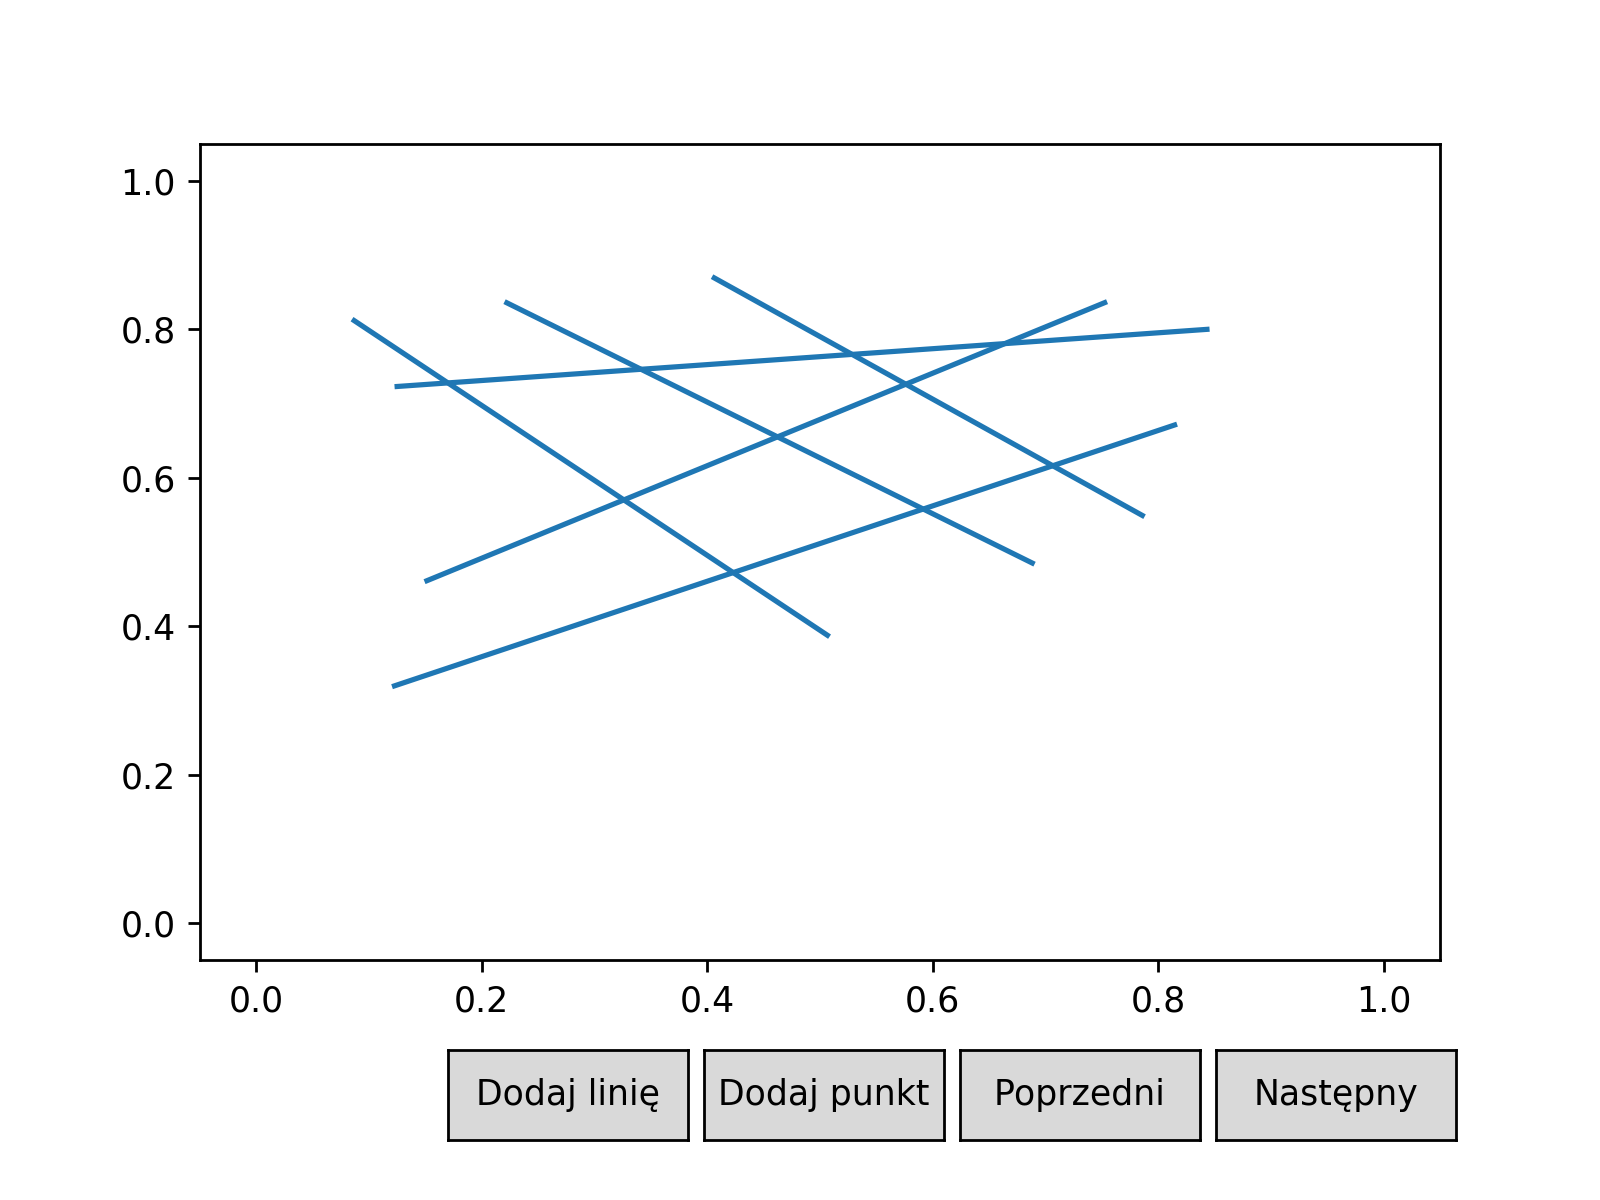

In [13]:
#Dodaj tu punkty i/lub odcinki!
plot = Plot()
plot.draw()

10
(0.42, 0.47)   [(0.12, 0.32), (0.82, 0.67)]   [(0.08, 0.81), (0.51, 0.39)]
(0.17, 0.73)   [(0.12, 0.72), (0.85, 0.8)]   [(0.08, 0.81), (0.51, 0.39)]
(0.66, 0.78)   [(0.15, 0.46), (0.75, 0.84)]   [(0.12, 0.72), (0.85, 0.8)]
(0.33, 0.57)   [(0.08, 0.81), (0.51, 0.39)]   [(0.15, 0.46), (0.75, 0.84)]
(0.34, 0.75)   [(0.22, 0.84), (0.69, 0.48)]   [(0.12, 0.72), (0.85, 0.8)]
(0.46, 0.66)   [(0.22, 0.84), (0.69, 0.48)]   [(0.15, 0.46), (0.75, 0.84)]
(0.53, 0.77)   [(0.4, 0.87), (0.79, 0.55)]   [(0.12, 0.72), (0.85, 0.8)]
(0.59, 0.56)   [(0.22, 0.84), (0.69, 0.48)]   [(0.12, 0.32), (0.82, 0.67)]
(0.58, 0.73)   [(0.4, 0.87), (0.79, 0.55)]   [(0.15, 0.46), (0.75, 0.84)]
(0.71, 0.62)   [(0.12, 0.32), (0.82, 0.67)]   [(0.4, 0.87), (0.79, 0.55)]


<IPython.core.display.Javascript object>


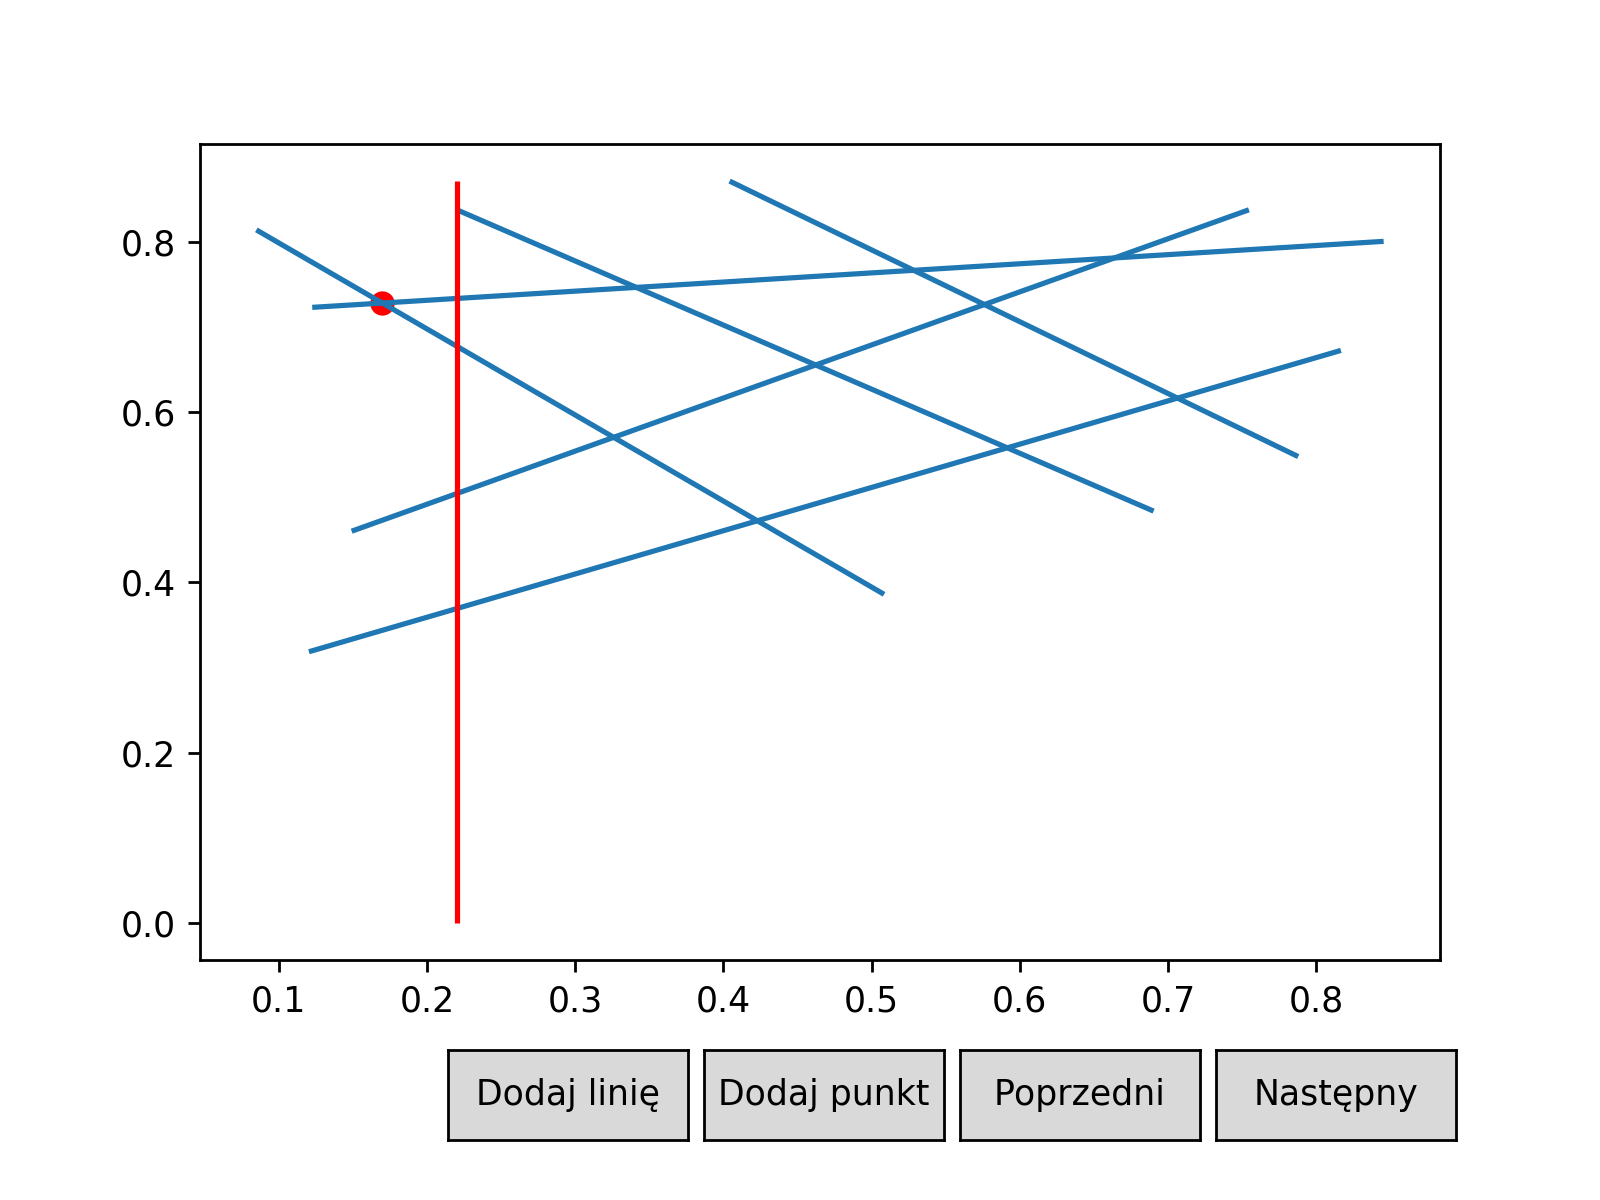

In [15]:
scenes = []
lines = filter_plot(0.01,plot.get_added_elements()).lines[0].lines
points = swipe(lines, scenes)
plot_result = Plot(scenes)
plot_result.draw()

<IPython.core.display.Javascript object>


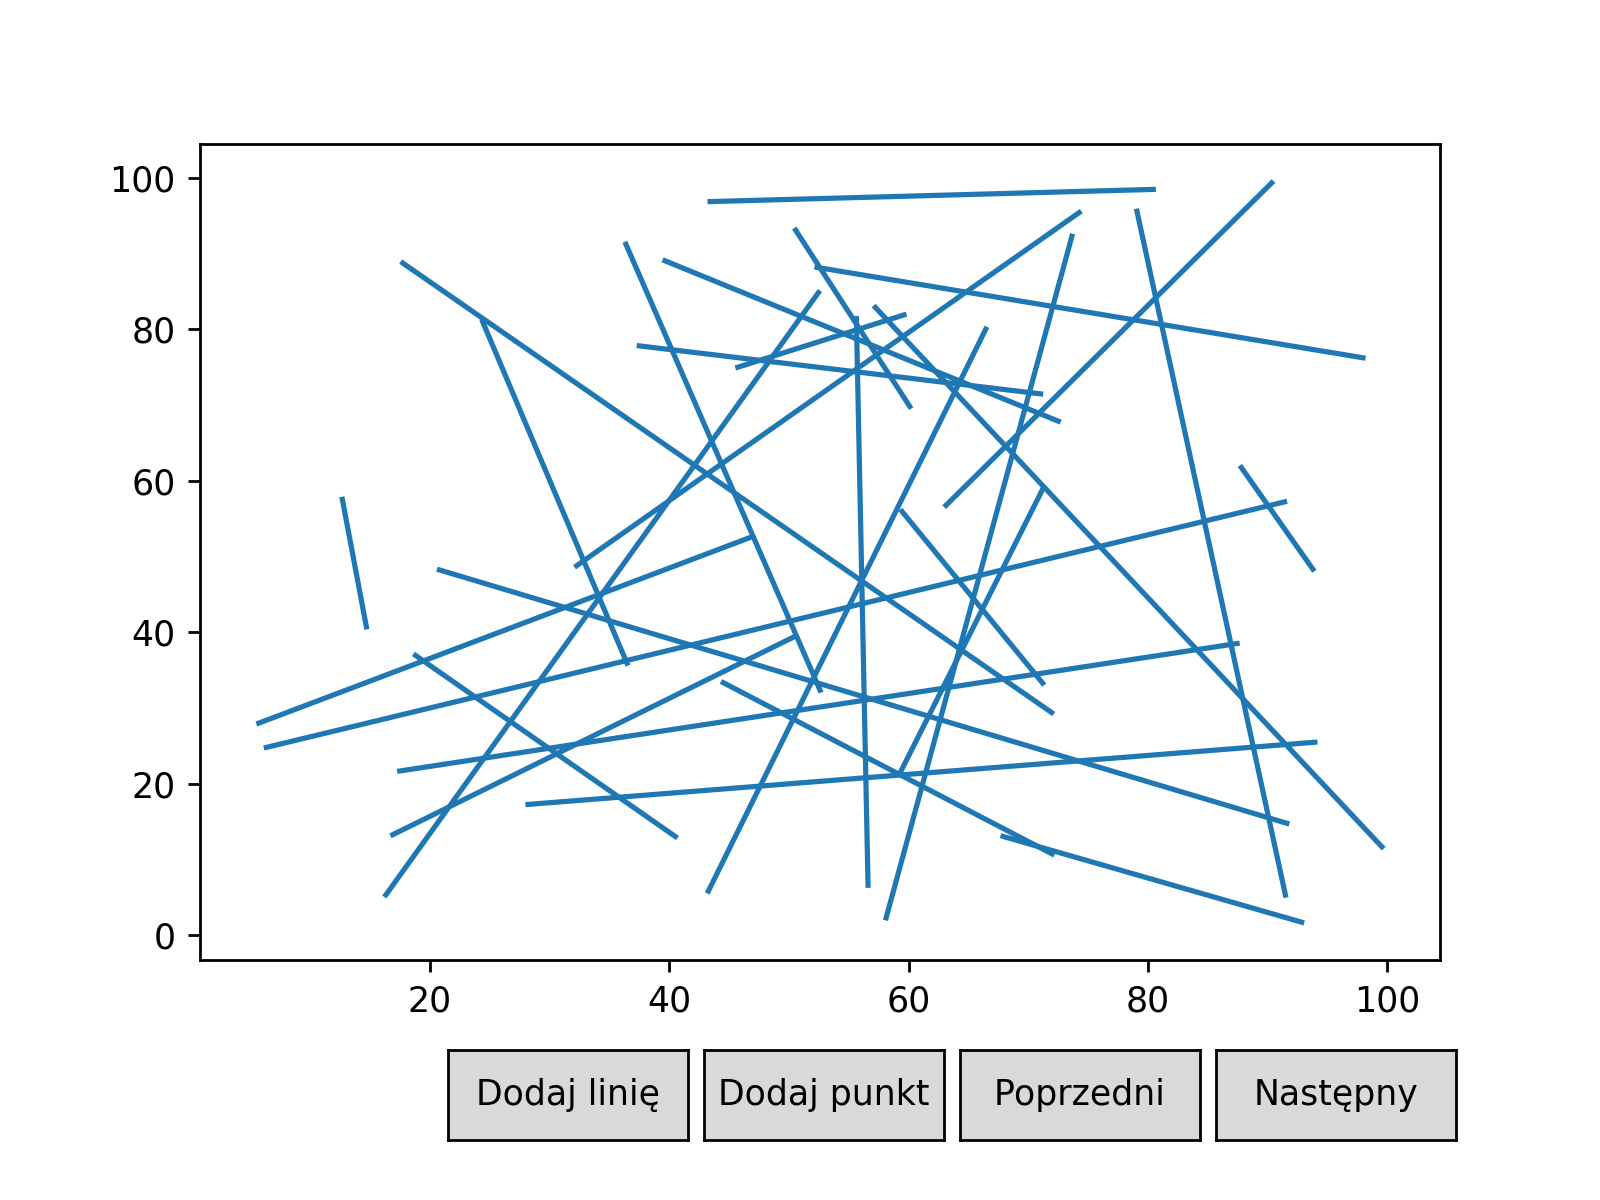

In [16]:
plot3 = Plot([])
plot3 = Plot([Scene(lines=[LinesCollection(generate_unique_random_lines(30, (0,100), (0,100)))])])
plot3.draw()

In [ ]:
scenes = []
lines = plot3.scenes[-1].lines[0].lines
points = swipe(lines, scenes)
plot_result = Plot([])
plot_result = Plot(scenes)
plot_result.draw()

### Wnioski
1. W algorytmie sprawdzającym, czy choć jedna para odcinków w zadanym zbiorze się przecina można było wykorzystać zwykłe posortowane listy jako struktury zdarzeń gdyż porządek lini jest stały. Zmiana porządku lini następuję w punkcie przecięcia, zatem w algorytmie który zatrzymuje się po wykryciu przecięcia nigdy nie dochodzi do zmiany porządku.
2. W algorytmie wykrywającym wszystkie przecięcia lini zastosowałem `SortedSet` jako strukturę stanu, ponieważ pozwala on na dodawanie i usuwanie elementów przy zachowaniu porządku. Obie te operacje wg. dokumentacji pakietu `sortedcontainers` mają złożoność `O(log(n))`. Jako strukturę zdarzeń wykorzystałem kopiec z pakietu `heapq` ponieważ w strukturze zdarzeń zależy nam na możliwości szybkiego wstawiania oraz pobierania wartości i zdejmowania elementu o najmniejszym kluczu. Operacja wstawiania i zdejmowania elementu z kopca ma złożoność `O(log(n))` natomiast złożoność pobierania wartości najmniejszej to `O(1)`, zatem satysfakcjonuje to wymagania jakie stawiamy przez algorytmem.
3. Układ odcinków dla którego wielokrotnie wykrywany jest jeden punkt:
    ![Brak Obrazka](./wykres.png)
    
    Na początku wykrywane jest przecięcie lini I i III, następnie gdy algorytm wykryje przecięcie lini II i III, sprawdzi też przecięcie lini II z sąsiadem na dole i lini III z sąsiadem na górze, górnym sąsiadem lini III jest linia I przez co przecięcie lini I i III zostanie ponownie wykryte. Problem ten rozwiązałem poprzez użycie `set`-a który pozwala na operację wstawiania i sprawdzania czy element należy do zbioru w czasie jednostkowym, zatem nie wpływa to na końcową złożoność algorytmu. Linią w zbiorze nadaję identyfikatory i w momencie sprawdzania przecinania między liniamy wrzucam parę ich identyfikatorów do zbioru, pozwala mi to na szybkie sprawdzenie czy dana para odcinków była już sprawdzana.